# PSM Segmentation from CH1 + CH2 Combined - Basic Version

## Overview

This notebook is the **basic version** of marker-free PSM segmentation, combining features from both Channel 1 and Channel 2. It was an intermediate step before developing the improved version.

## Purpose

This experiment showed that combining CH1 and CH2 features improves over single-channel approaches, but still suffers from over-segmentation. **Result**: Dice ~0.49, better than single channels but not sufficient.

## What This Notebook Does

1. Extracts 5 texture features from each channel (10 total)
2. Trains a Random Forest using Channel 3 masks as ground truth
3. Predicts PSM on test frames

## Limitations (Solved in Improved Version)

- No position features (model doesn't know WHERE to look)
- Negatives sampled from all background (not just nearby tissue)
- No size/location filtering of predictions

## Comparison

| Method | Mean Dice |
|--------|-----------|
| CH2 only | 0.26 |
| CH1 only | 0.42 |
| **CH1+CH2 basic** | **0.49** |
| CH1+CH2 improved | 0.70 |

## How to Use

This notebook is provided for reproducibility. For best results, use `PSM_From_CH1_CH2_Improved.ipynb` instead.


In [1]:
# %% CELL 1: SETUP & LIBRARIES
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tifffile import imread, imwrite

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

from skimage import filters, morphology, measure, transform

from sklearn.ensemble import RandomForestClassifier
import joblib

np.random.seed(42)
print("Imports loaded.")


Imports loaded.


In [2]:
# %% CELL 2: CONFIGURATION
# This model uses BOTH Channel 1 and Channel 2 as input (10 features total)
# Ground truth comes from Channel 3 masks

# =============================================================================
# USER CONFIGURATION (CHANGE THESE)
# =============================================================================
MASK_FOLDER = "mask_santi"                      # Folder with CH3 masks for training
OUTPUT_FOLDER = "psm_from_ch1_ch2"              # Output folder for this model

# =============================================================================
# AUTO-DETECT DATA LOCATION
# =============================================================================
current_dir = Path(".")
parent_dir = Path("..")

if (current_dir / MASK_FOLDER).exists():
    BASE_DIR = current_dir
elif (parent_dir / MASK_FOLDER).exists():
    BASE_DIR = parent_dir
else:
    BASE_DIR = parent_dir
    print(f"[WARNING] Could not find '{MASK_FOLDER}'. Set BASE_DIR manually.")

RAW_DIR = BASE_DIR
GT_MASK_DIR = BASE_DIR / MASK_FOLDER

# Output folder for this combined model
OUTPUT_DIR = BASE_DIR / OUTPUT_FOLDER
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = OUTPUT_DIR / "rf_model_psm_from_ch1_ch2.joblib"
FEATURE_STATS_PATH = OUTPUT_DIR / "feature_stats.joblib"
PROGRESS_PATH = OUTPUT_DIR / "progress.json"
RESULTS_PATH = OUTPUT_DIR / "results.csv"
VIZ_DIR = OUTPUT_DIR / "visualizations"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Training frames (same as Channel 3 pipeline)
TRAINING_FRAMES = [1, 30, 70, 120, 140, 180, 200]

# Quick test mode
TEST_MODE = True
TEST_FRAMES = [30, 60, 120, 150, 200]

# Processing parameters
SCALE_FACTOR = 0.25
SLICE_OFFSET = 8
SAFE_EROSION_RADIUS = 2
SAFE_DILATION_RADIUS = 2
CLOSING_RADIUS_3D = 8
SMOOTH_SIGMA = 2.0
EVAL_Z_SLICE = 188

print("Configuration:")
print(f"  INPUT CHANNELS    : 1 + 2 (combined)")
print(f"  TEST_MODE         : {TEST_MODE}")
print(f"  TEST_FRAMES       : {TEST_FRAMES}")
print(f"  TRAINING_FRAMES   : {TRAINING_FRAMES}")
print(f"  GT_MASK_DIR       : {GT_MASK_DIR}")
print(f"  OUTPUT_DIR        : {OUTPUT_DIR}")


Configuration:
  INPUT CHANNELS    : 1 + 2 (combined)
  TEST_MODE         : True
  TEST_FRAMES       : [30, 60, 120, 150, 200]
  TRAINING_FRAMES   : [1, 30, 70, 120, 140, 180, 200]
  GT_MASK_DIR       : ../mask_santi
  OUTPUT_DIR        : ../psm_from_ch1_ch2


In [3]:
# %% CELL 3: FEATURE ENGINEERING (10 FEATURES: 5 from CH1 + 5 from CH2)
# For each pixel we extract:
# - From Channel 1: intensity, gaussian(1.5), gaussian(3.5), gaussian(8.0), sobel
# - From Channel 2: intensity, gaussian(1.5), gaussian(3.5), gaussian(8.0), sobel
# Total: 10 features per pixel

def get_single_channel_features(image_2d: np.ndarray, channel_name: str):
    """Extract 5 multi-scale features for each pixel in a 2D slice from one channel."""
    image_2d = image_2d.astype(np.float32, copy=False)

    feats = []
    names = []

    feats.append(image_2d.flatten())
    names.append(f"{channel_name} Intensity")

    feats.append(filters.gaussian(image_2d, sigma=1.5).flatten())
    names.append(f"{channel_name} Texture (1.5)")

    feats.append(filters.gaussian(image_2d, sigma=3.5).flatten())
    names.append(f"{channel_name} Shape (3.5)")

    feats.append(filters.gaussian(image_2d, sigma=8.0).flatten())
    names.append(f"{channel_name} Context (8.0)")

    feats.append(filters.sobel(image_2d).flatten())
    names.append(f"{channel_name} Edges")

    return feats, names


def get_combined_features(ch1_2d: np.ndarray, ch2_2d: np.ndarray):
    """Extract 10 features: 5 from Channel 1 + 5 from Channel 2."""
    feats1, names1 = get_single_channel_features(ch1_2d, "CH1")
    feats2, names2 = get_single_channel_features(ch2_2d, "CH2")

    all_feats = feats1 + feats2
    all_names = names1 + names2

    X = np.vstack(all_feats).T
    return X, all_names


In [4]:
# %% CELL 4: DATA LOADING AND TRAINING

def raw_file(t: int, channel: int) -> Path:
    return RAW_DIR / f"t{t:04d}_Channel {channel}.tif"


def gt_mask_file(t: int) -> Path:
    return GT_MASK_DIR / f"mask_t{t:04d}_Channel 3.tif"


def load_raw_volume(t: int, channel: int) -> np.ndarray:
    p = raw_file(t, channel)
    if not p.exists():
        raise FileNotFoundError(f"Missing raw file: {p}")
    return imread(str(p))


def load_gt_mask_volume(t: int) -> np.ndarray:
    p = gt_mask_file(t)
    if not p.exists():
        raise FileNotFoundError(f"Missing GT mask file: {p}")
    m = imread(str(p))
    return (m > 0)


def dice_score(pred: np.ndarray, gt: np.ndarray) -> float:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return 1.0 if denom == 0 else (2.0 * inter / denom)


def iou_score(pred: np.ndarray, gt: np.ndarray) -> float:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1.0 if union == 0 else (inter / union)


def generate_training_data_combined(ch1_vol: np.ndarray, ch2_vol: np.ndarray, gt_vol: np.ndarray, scale: float):
    """Generate balanced training samples using CH1+CH2 features and CH3 GT masks."""
    # Downsample all volumes
    small_ch1 = transform.rescale(
        ch1_vol.astype(np.float32, copy=False), scale,
        preserve_range=True, anti_aliasing=True
    ).astype(np.float32)

    small_ch2 = transform.rescale(
        ch2_vol.astype(np.float32, copy=False), scale,
        preserve_range=True, anti_aliasing=True
    ).astype(np.float32)

    small_gt = transform.resize(
        gt_vol.astype(np.float32), small_ch1.shape,
        order=0, preserve_range=True, anti_aliasing=False
    ) > 0.5

    zc = small_ch1.shape[0] // 2
    z_slices = [zc, zc - SLICE_OFFSET, zc + SLICE_OFFSET]

    X_list, y_list = [], []

    for z in z_slices:
        if z < 0 or z >= small_ch1.shape[0]:
            continue

        img1 = small_ch1[z]
        img2 = small_ch2[z]
        msk = small_gt[z]

        msz = int(msk.sum())
        if msz < 50 or msz > 25000:
            continue

        safe_tissue = morphology.binary_erosion(msk, morphology.disk(SAFE_EROSION_RADIUS))
        unsafe = morphology.binary_dilation(msk, morphology.disk(SAFE_DILATION_RADIUS))
        safe_bg = ~unsafe

        labels = np.zeros(img1.shape, dtype=np.uint8)
        labels[safe_tissue] = 1
        labels[safe_bg] = 2

        X, _ = get_combined_features(img1, img2)
        y = labels.flatten()

        idx_pos = np.where(y == 1)[0]
        idx_neg = np.where(y == 2)[0]

        n = min(len(idx_pos), len(idx_neg))
        if n == 0:
            continue

        idx_pos = np.random.choice(idx_pos, size=n, replace=False)
        idx_neg = np.random.choice(idx_neg, size=n, replace=False)
        idx = np.concatenate([idx_pos, idx_neg])

        X_list.append(X[idx])
        y_list.append(y[idx])

    if not X_list:
        return None, None

    return np.vstack(X_list), np.concatenate(y_list)


def train_combined_model(training_frames):
    """Train Random Forest using CH1+CH2 features and CH3 masks as GT."""
    X_all, y_all = [], []

    for t in training_frames:
        print(f"Loading training frame t={t:04d}...")
        ch1_vol = load_raw_volume(t, 1)
        ch2_vol = load_raw_volume(t, 2)
        gt_vol = load_gt_mask_volume(t)

        X, y = generate_training_data_combined(ch1_vol, ch2_vol, gt_vol, SCALE_FACTOR)
        if X is not None:
            X_all.append(X)
            y_all.append(y)
            print(f"  Added {len(y):,} labeled pixels (balanced).")
        else:
            print("  Skipped (no valid slices).")

        del ch1_vol, ch2_vol, gt_vol

    if not X_all:
        raise RuntimeError("No training data could be generated.")

    X_train = np.vstack(X_all)
    y_train = np.concatenate(y_all)

    print(f"Training Random Forest on {len(y_train):,} pixels with 10 features...")

    clf = RandomForestClassifier(
        n_estimators=100,  # More trees for more features
        max_depth=15,      # Slightly deeper
        n_jobs=-1,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    _, feat_names = get_combined_features(
        np.zeros((10, 10), dtype=np.float32),
        np.zeros((10, 10), dtype=np.float32)
    )
    feature_stats = (feat_names, clf.feature_importances_)

    joblib.dump(clf, MODEL_PATH)
    joblib.dump(feature_stats, FEATURE_STATS_PATH)

    print(f"Saved model to: {MODEL_PATH}")
    return clf, feature_stats


In [5]:
# %% CELL 5: PREDICTION & POST-PROCESSING

def predict_psm_3d_combined(clf, ch1_vol: np.ndarray, ch2_vol: np.ndarray):
    """Predict 3D PSM mask using CH1+CH2 combined features."""
    t0 = time.time()
    orig_shape = ch1_vol.shape

    small_ch1 = transform.rescale(
        ch1_vol.astype(np.float32, copy=False), SCALE_FACTOR,
        preserve_range=True, anti_aliasing=True
    ).astype(np.float32)

    small_ch2 = transform.rescale(
        ch2_vol.astype(np.float32, copy=False), SCALE_FACTOR,
        preserve_range=True, anti_aliasing=True
    ).astype(np.float32)

    mask_small = np.zeros(small_ch1.shape, dtype=np.uint8)

    for z in range(small_ch1.shape[0]):
        X, _ = get_combined_features(small_ch1[z], small_ch2[z])
        pred = clf.predict(X)
        mask_small[z] = (pred == 1).reshape(small_ch1.shape[1], small_ch1.shape[2]).astype(np.uint8)

    # 3D cleanup
    mask_small = morphology.binary_closing(mask_small > 0, morphology.ball(CLOSING_RADIUS_3D))
    mask_small = ndi.binary_fill_holes(mask_small)

    # Upsample
    full_mask = transform.resize(mask_small.astype(np.float32), orig_shape, order=0, preserve_range=True) > 0.5
    full_mask = gaussian_filter(full_mask.astype(np.float32), sigma=SMOOTH_SIGMA) > 0.5

    # Keep largest component
    lbl = measure.label(full_mask)
    if lbl.max() > 0:
        sizes = np.bincount(lbl.ravel())
        sizes[0] = 0
        full_mask = (lbl == sizes.argmax())

    elapsed = time.time() - t0
    vol_px = int(full_mask.sum())
    return full_mask.astype(np.uint8), elapsed, vol_px


No saved model found. Training with CH1+CH2 combined...
Loading training frame t=0001...
  Added 59,456 labeled pixels (balanced).
Loading training frame t=0030...
  Added 56,794 labeled pixels (balanced).
Loading training frame t=0070...
  Added 12,162 labeled pixels (balanced).
Loading training frame t=0120...
  Added 13,918 labeled pixels (balanced).
Loading training frame t=0140...
  Added 17,130 labeled pixels (balanced).
Loading training frame t=0180...
  Added 11,928 labeled pixels (balanced).
Loading training frame t=0200...
  Added 10,572 labeled pixels (balanced).
Training Random Forest on 181,960 pixels with 10 features...
Saved model to: psm_from_ch1_ch2/rf_model_psm_from_ch1_ch2.joblib

Feature Importance:
  CH1 Context (8.0)        : 0.288
  CH1 Shape (3.5)          : 0.218
  CH1 Texture (1.5)        : 0.166
  CH1 Intensity            : 0.144
  CH2 Shape (3.5)          : 0.068
  CH2 Context (8.0)        : 0.064
  CH2 Texture (1.5)        : 0.024
  CH2 Intensity           

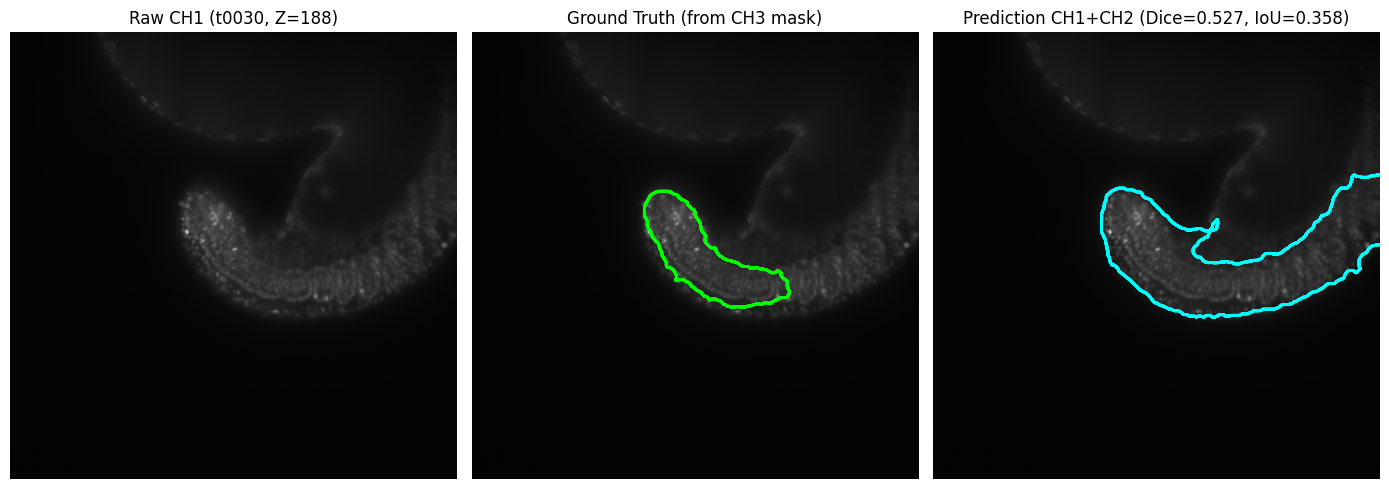

Saved: psm_from_ch1_ch2/mask_t0030_from_CH1_CH2.tif
Dice@Z=188: 0.527 | IoU@Z=188: 0.358 | time: 239.4s

[2/5] Processing t0060 (CH1+CH2 combined)...


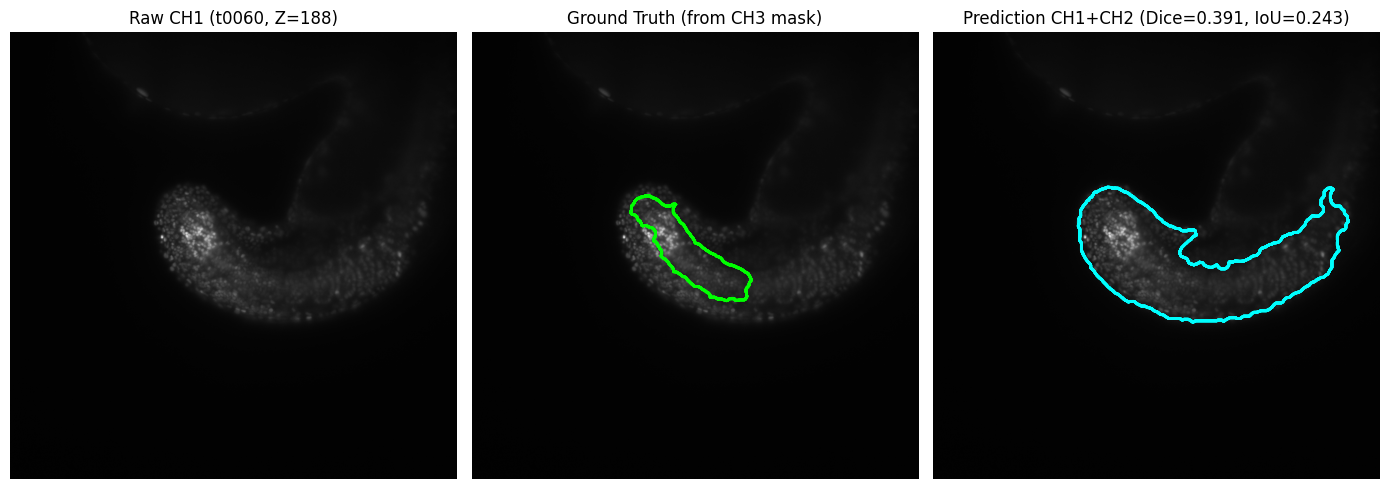

Saved: psm_from_ch1_ch2/mask_t0060_from_CH1_CH2.tif
Dice@Z=188: 0.391 | IoU@Z=188: 0.243 | time: 234.9s

[3/5] Processing t0120 (CH1+CH2 combined)...


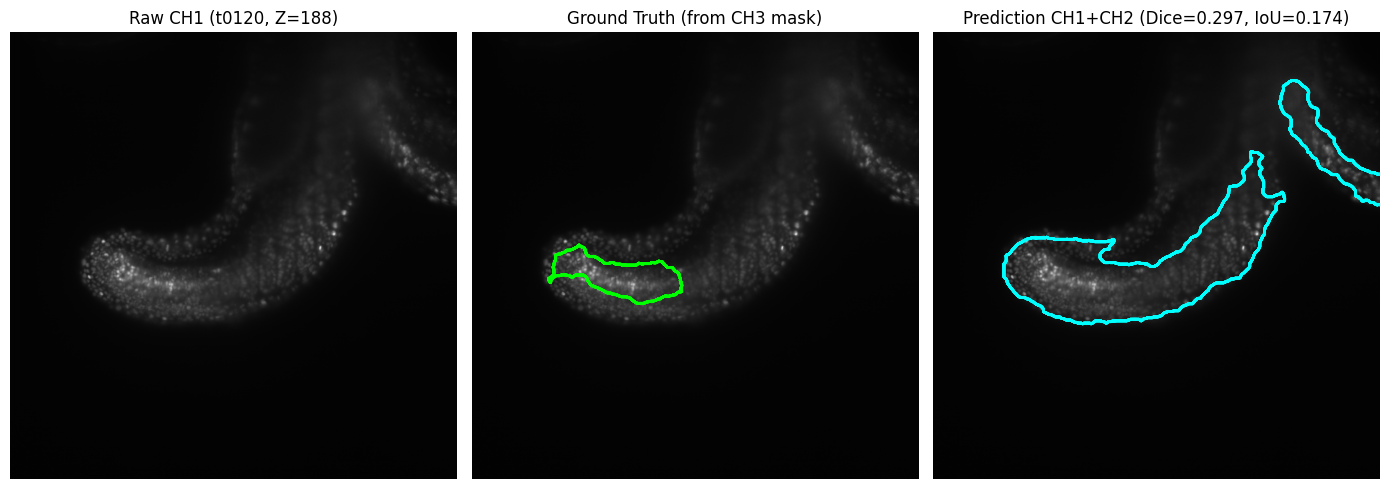

Saved: psm_from_ch1_ch2/mask_t0120_from_CH1_CH2.tif
Dice@Z=188: 0.297 | IoU@Z=188: 0.174 | time: 234.9s

[4/5] Processing t0150 (CH1+CH2 combined)...


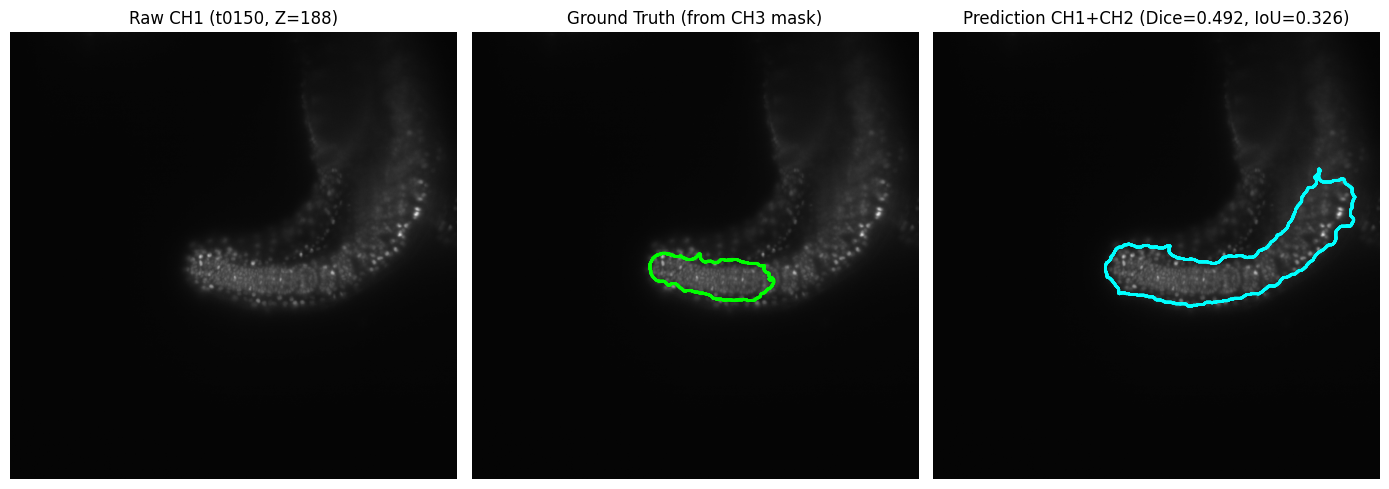

Saved: psm_from_ch1_ch2/mask_t0150_from_CH1_CH2.tif
Dice@Z=188: 0.492 | IoU@Z=188: 0.326 | time: 233.8s

[5/5] Processing t0200 (CH1+CH2 combined)...


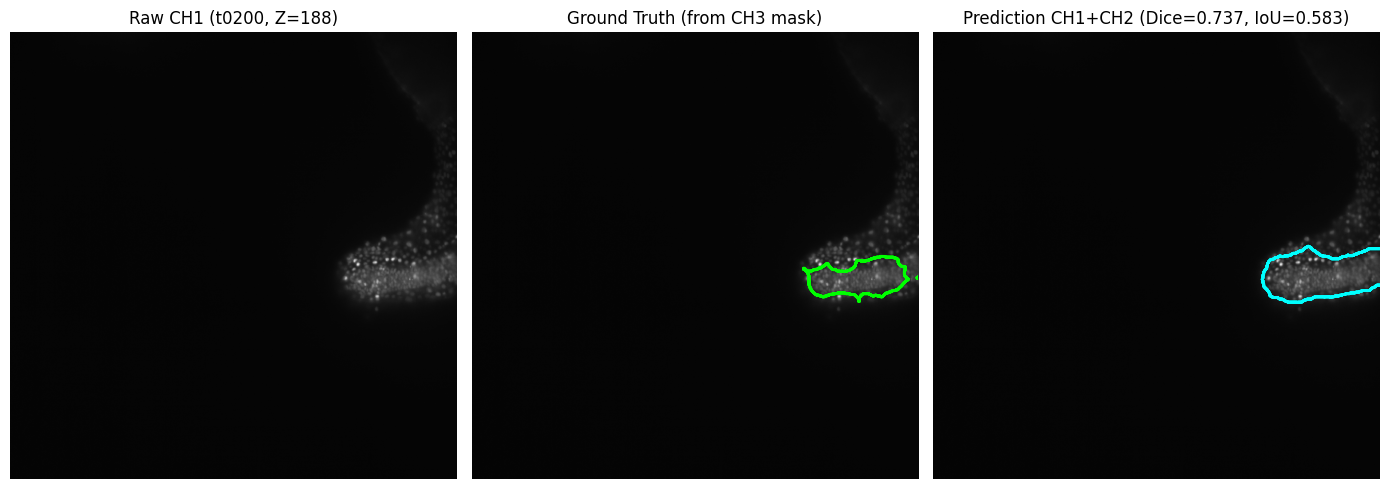

Saved: psm_from_ch1_ch2/mask_t0200_from_CH1_CH2.tif
Dice@Z=188: 0.737 | IoU@Z=188: 0.583 | time: 228.8s

Done.
Results: psm_from_ch1_ch2/results.csv
Model  : psm_from_ch1_ch2/rf_model_psm_from_ch1_ch2.joblib


In [6]:
# %% CELL 6: MAIN (TEST MODE BY DEFAULT)

# Load or train model
if MODEL_PATH.exists():
    print(f"Loading existing model: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    feature_stats = joblib.load(FEATURE_STATS_PATH) if FEATURE_STATS_PATH.exists() else None
else:
    print("No saved model found. Training with CH1+CH2 combined...")
    model, feature_stats = train_combined_model(TRAINING_FRAMES)

# Show feature importance
if feature_stats:
    feat_names, feat_imp = feature_stats
    print("\nFeature Importance:")
    for name, imp in sorted(zip(feat_names, feat_imp), key=lambda x: -x[1]):
        print(f"  {name:25s}: {imp:.3f}")

# Load checkpoint
processed = []
if PROGRESS_PATH.exists():
    processed = json.loads(PROGRESS_PATH.read_text()).get("processed", [])

frames_to_run = TEST_FRAMES if TEST_MODE else list(range(1, 220))

rows = []
if RESULTS_PATH.exists():
    try:
        rows = pd.read_csv(RESULTS_PATH).to_dict("records")
    except Exception:
        rows = []

for i, t in enumerate(frames_to_run):
    key = f"t{t:04d}"
    if key in processed:
        continue

    print(f"\n[{i+1}/{len(frames_to_run)}] Processing {key} (CH1+CH2 combined)...")

    try:
        ch1_vol = load_raw_volume(t, 1)
        ch2_vol = load_raw_volume(t, 2)
        gt_vol = load_gt_mask_volume(t)

        pred_mask, elapsed, vol_px = predict_psm_3d_combined(model, ch1_vol, ch2_vol)

        # Save mask
        out_mask_path = OUTPUT_DIR / f"mask_{key}_from_CH1_CH2.tif"
        imwrite(str(out_mask_path), pred_mask * 255)

        # Evaluate at slice Z=188
        z = EVAL_Z_SLICE
        if z >= pred_mask.shape[0]:
            z = pred_mask.shape[0] // 2

        dice = dice_score(pred_mask[z] > 0, gt_vol[z] > 0)
        iou = iou_score(pred_mask[z] > 0, gt_vol[z] > 0)

        rows.append({
            "timepoint": t,
            "channels": "1+2",
            "elapsed_s": float(elapsed),
            "volume_px": int(vol_px),
            "eval_z": int(z),
            "dice_z": float(dice),
            "iou_z": float(iou),
            "pred_mask": str(out_mask_path),
        })

        pd.DataFrame(rows).to_csv(RESULTS_PATH, index=False)

        processed.append(key)
        PROGRESS_PATH.write_text(json.dumps({"processed": processed}, indent=2))

        # Visualization (show CH1 as background)
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        ax[0].imshow(ch1_vol[z], cmap="gray")
        ax[0].set_title(f"Raw CH1 ({key}, Z={z})")
        ax[0].axis("off")

        ax[1].imshow(ch1_vol[z], cmap="gray")
        ax[1].contour((gt_vol[z] > 0).astype(np.uint8), colors="lime", linewidths=2)
        ax[1].set_title("Ground Truth (from CH3 mask)")
        ax[1].axis("off")

        ax[2].imshow(ch1_vol[z], cmap="gray")
        ax[2].contour((pred_mask[z] > 0).astype(np.uint8), colors="cyan", linewidths=2)
        ax[2].set_title(f"Prediction CH1+CH2 (Dice={dice:.3f}, IoU={iou:.3f})")
        ax[2].axis("off")

        plt.tight_layout()
        viz_path = VIZ_DIR / f"viz_{key}_CH1_CH2.png"
        fig.savefig(viz_path, dpi=120, bbox_inches="tight")
        plt.show()
        plt.close(fig)

        print(f"Saved: {out_mask_path}")
        print(f"Dice@Z={z}: {dice:.3f} | IoU@Z={z}: {iou:.3f} | time: {elapsed:.1f}s")

    except Exception as e:
        print(f"ERROR on {key}: {e}")
    finally:
        try:
            del ch1_vol, ch2_vol, gt_vol, pred_mask
        except Exception:
            pass

print("\nDone.")
print(f"Results: {RESULTS_PATH}")
print(f"Model  : {MODEL_PATH}")


,timepoint,channels,elapsed_s,volume_px,eval_z,dice_z,iou_z,pred_mask
0,30,1+2,239.392902,84527811,188,0.527400,0.358142,psm_from_ch1_ch2/mask_t0030_from_CH1_CH2.tif
1,60,1+2,234.896272,75243024,188,0.391334,0.243266,psm_from_ch1_ch2/mask_t0060_from_CH1_CH2.tif
2,120,1+2,234.901661,73814824,188,0.297089,0.174459,psm_from_ch1_ch2/mask_t0120_from_CH1_CH2.tif
3,150,1+2,233.822330,59320902,188,0.491823,0.326105,psm_from_ch1_ch2/mask_t0150_from_CH1_CH2.tif
4,200,1+2,228.762208,12519410,188,0.736911,0.583420,psm_from_ch1_ch2/mask_t0200_from_CH1_CH2.tif



Summary (CH1+CH2 combined):
         dice_z     iou_z   elapsed_s
count  5.000000  5.000000    5.000000
mean   0.488912  0.337078  234.355075
std    0.165311  0.155317    3.792602
min    0.297089  0.174459  228.762208
25%    0.391334  0.243266  233.822330
50%    0.491823  0.326105  234.896272
75%    0.527400  0.358142  234.901661
max    0.736911  0.583420  239.392902


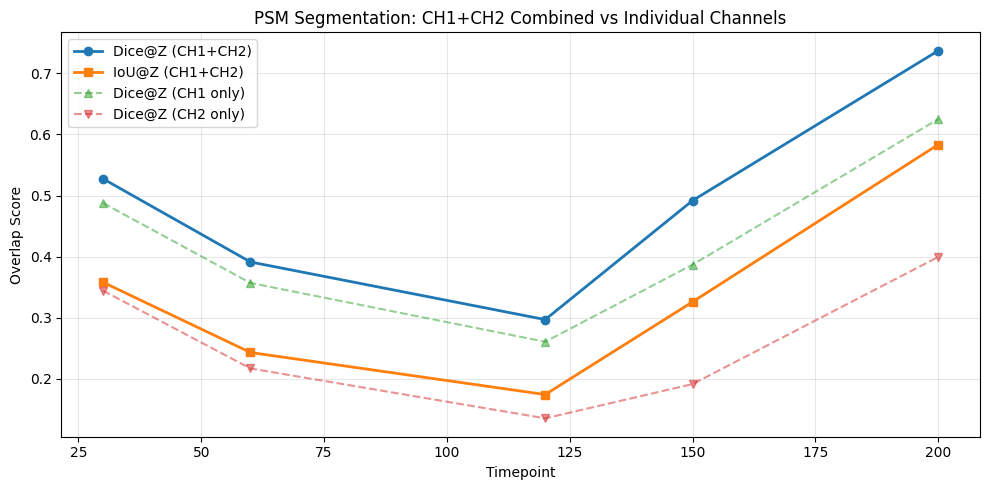


Saved comparison plot: psm_from_ch1_ch2/plot_comparison.png


In [7]:
# %% CELL 7: SUMMARY AND COMPARISON

if RESULTS_PATH.exists():
    df = pd.read_csv(RESULTS_PATH).sort_values("timepoint")
    display(df)

    print("\nSummary (CH1+CH2 combined):")
    print(df[["dice_z", "iou_z", "elapsed_s"]].describe())

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["timepoint"], df["dice_z"], marker="o", linewidth=2, label="Dice@Z (CH1+CH2)")
    plt.plot(df["timepoint"], df["iou_z"], marker="s", linewidth=2, label="IoU@Z (CH1+CH2)")
    
    # Add reference lines for CH1-only and CH2-only if available
    ch1_results = Path("psm_from_ch1/results.csv")
    ch2_results = Path("psm_from_ch2/results.csv")
    
    if ch1_results.exists():
        df1 = pd.read_csv(ch1_results).sort_values("timepoint")
        plt.plot(df1["timepoint"], df1["dice_z"], marker="^", linestyle="--", alpha=0.5, label="Dice@Z (CH1 only)")
    
    if ch2_results.exists():
        df2 = pd.read_csv(ch2_results).sort_values("timepoint")
        plt.plot(df2["timepoint"], df2["dice_z"], marker="v", linestyle="--", alpha=0.5, label="Dice@Z (CH2 only)")

    plt.xlabel("Timepoint")
    plt.ylabel("Overlap Score")
    plt.title("PSM Segmentation: CH1+CH2 Combined vs Individual Channels")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    out_plot = OUTPUT_DIR / "plot_comparison.png"
    plt.savefig(out_plot, dpi=150, bbox_inches="tight")
    plt.show()

    print(f"\nSaved comparison plot: {out_plot}")
else:
    print("No results.csv found yet. Run Cell 6 first.")

